In [ ]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

#### load a NIfTI file

In [ ]:
def load_nifti(file_path):
    """
    Loads a NIfTI (.nii or .nii.gz) file and returns it as a NumPy array
    """
    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    return data

#### load FLAIR MRI and Mask for one patient

In [ ]:
def load_patient_data(folder_path, patient_id):
    """
    Loads FLAIR MRI and segmentation mask from a flat folder structure
    """
    flair_path = f"{folder_path}/BraTS2021_{patient_id}_flair.nii"
    mask_path  = f"{folder_path}/BraTS2021_{patient_id}_seg.nii"

    flair = load_nifti(flair_path)
    mask  = load_nifti(mask_path)

    return flair, mask



In [ ]:
def load_patient_data(folder_path, patient_id):
    """
    Loads FLAIR MRI and segmentation mask from a flat folder structure
    Adjusted to correctly locate files in /content/ with .nii.gz extension
    """
    flair_path = f"{folder_path}/BraTS2021_{patient_id}_flair.nii.gz"
    mask_path  = f"{folder_path}/BraTS2021_{patient_id}_seg.nii.gz"

    flair = load_nifti(flair_path)
    mask  = load_nifti(mask_path)

    return flair, mask

# Set the correct folder path to /content where the files are located
folder_path = "/content"
patient_id = "01165"

flair, mask = load_patient_data(folder_path, patient_id)

print("FLAIR shape:", flair.shape)
print("Mask shape :", mask.shape)

FLAIR shape: (240, 240, 155)
Mask shape : (240, 240, 155)


#### Convert 3D Volume to 2D Slices

In [ ]:
def extract_slices(volume, mask):
    images = []
    masks = []

    for i in range(volume.shape[2]):
        images.append(volume[:, :, i])
        masks.append(mask[:, :, i])

    return np.array(images), np.array(masks)


In [ ]:
images, masks = extract_slices(flair, mask)

print("Images shape:", images.shape)
print("Masks shape :", masks.shape)

## (number_of_slices, height, width)



Images shape: (155, 240, 240)
Masks shape : (155, 240, 240)


#### Remove Empty (No-Tumor) Slices


In [ ]:

def remove_empty_slices(images, masks):
    img_out, mask_out = [], []

    for img, msk in zip(images, masks):
        if np.sum(msk) > 0:
            img_out.append(img)
            mask_out.append(msk)

    return np.array(img_out), np.array(mask_out)


#### Normalize & Resize

In [ ]:
def preprocess(images, masks, size=128):
    X, Y = [], []

    for img, msk in zip(images, masks):
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = cv2.resize(img, (size, size))
        msk = cv2.resize(msk, (size, size))

        X.append(img)
        Y.append(msk)

    X = np.array(X)[..., np.newaxis]
    Y = np.array(Y)[..., np.newaxis]

    return X, Y


In [ ]:
X, Y = preprocess(images, masks)
print(X.shape, Y.shape)

(155, 128, 128, 1) (155, 128, 128, 1)


#### Train–Validation Split

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


#### Build U-Net Model

In [ ]:

def unet(input_shape=(128,128,1)):## Input Layer
    inputs = Input(input_shape)
## Encoder (Contracting Path)
## Encoder Block 1
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)


## Encoder Block 2
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

## Bottleneck (Deepest Layer)
    b = Conv2D(256, 3, activation='relu', padding='same')(p2)

##Decoder
## Decoder Block 1
    u1 = UpSampling2D()(b)
    u1 = Concatenate()([u1, c2])
    c3 = Conv2D(128, 3, activation='relu', padding='same')(u1)

 ##Decoder Block 2
    u2 = UpSampling2D()(c3)
    u2 = Concatenate()([u2, c1])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u2)

 ## Output Layer
    outputs = Conv2D(1, 1, activation='sigmoid')(c4)
 ## Create Model
    model = Model(inputs, outputs)
    return model






#### Create the Model

In [ ]:
model = unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │         65 │ conv2d_6[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,107,393 (4.22 MB)

 Trainable params: 1,107,393 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Define Loss Function & Metrics

In [ ]:
## Dice Coefficient
import tensorflow as tf

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

#### IoU (Intersection over Union)

In [ ]:
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union


#### Compile the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)


#### Train the Model

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=8
)
print(history)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - dice_coef: 0.0411 - iou: 0.0216 - loss: 0.4261 - val_dice_coef: 0.2572 - val_iou: 0.1475 - val_loss: 0.0565
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - dice_coef: 0.1984 - iou: 0.1133 - loss: 0.0552 - val_dice_coef: 0.2769 - val_iou: 0.1607 - val_loss: 0.0526
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - dice_coef: 0.2254 - iou: 0.1286 - loss: 0.0532 - val_dice_coef: 0.3172 - val_iou: 0.1885 - val_loss: 0.0478
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - dice_coef: 0.2588 - iou: 0.1513 - loss: 0.0478 - val_dice_coef: 0.3538 - val_iou: 0.2149 - val_loss: 0.0454
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - dice_coef: 0.2868 - iou: 0.1690 - loss: 0.0476 - val_dice_coef: 0.3898 - val_iou: 0.2421 - val_loss: 0.0412
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - dice_coef: 0.3199 - iou: 0.1944 - loss: 0.0465 - val_dice_coef: 0.4188 - val_iou: 0.2649 - val_loss: 0.0366
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 81

#### Evaluate the Model

In [ ]:
results = model.evaluate(X_val, Y_val)
print("Validation Loss, Dice, IoU:", results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - dice_coef: 0.7294 - iou: 0.5740 - loss: -0.0769
Validation Loss, Dice, IoU: [-0.07689284533262253, 0.729396641254425, 0.5740440487861633]


#### Make Predictions

In [ ]:
predicted_masks = model.predict(X_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


#### Visualize

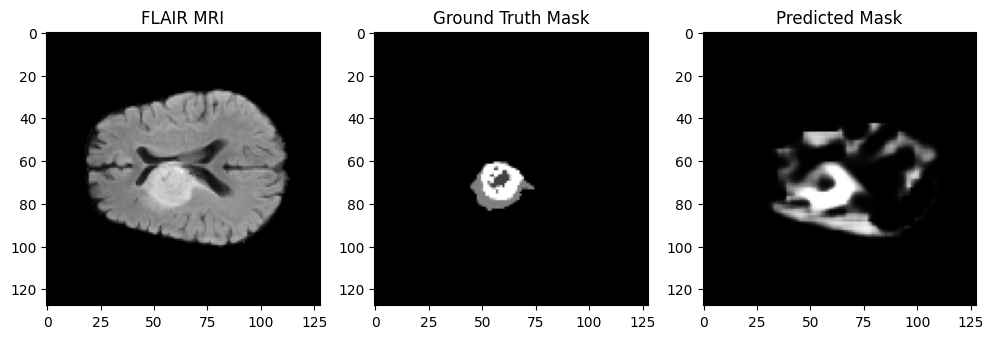

In [ ]:
import matplotlib.pyplot as plt

idx = 0

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("FLAIR MRI")
plt.imshow(X_val[idx,:,:,0], cmap='gray')

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(Y_val[idx,:,:,0], cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(predicted_masks[idx,:,:,0], cmap='gray')

plt.show()
